In [360]:
# Import modules

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd
from random import random
from matplotlib import pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from pdb import set_trace as keyboard

In [361]:
# Importing the csv file first and print a summary
# Edit this part##################################
State_abbrv = 'WI'
##################################################

In [362]:
# Code based on https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order, exogenous):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    train_eg, test_eg = exogenous[0:train_size,:], exogenous[train_size:,:]
    history = [x for x in train]
    exogen = [y for y in train_eg]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order, exog=exogen)
        model_fit = model.fit()
        #print(model_fit.summary())
        yhat = model_fit.forecast(1,alpha=0.05,exog=test_eg[t,:])[0]
        predictions.append(yhat)
        history.append(test[t])
        exogen.append(test_eg[t,:])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, exogenous):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order, exogenous)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [363]:
filename = './' + State_abbrv + '_EV_sales_data_final.csv'
filename2 = './' + State_abbrv + '_Exogenous_ARIMA_prediction_data.csv'
filename3 = './' + State_abbrv + '_EV_sales_prediction_data.csv'
State_df = pd.read_csv(filename)
State_df.info()
State_df.head()
State_df.keys()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 8 non-null      int64  
 1   Unnamed: 0.1               8 non-null      int64  
 2   Year                       8 non-null      int64  
 3   BEV sales                  8 non-null      int64  
 4   PHEV sales                 8 non-null      int64  
 5   Total                      8 non-null      int64  
 6   Gasoline Price             8 non-null      float64
 7   Median Income              8 non-null      int64  
 8   Population                 8 non-null      int64  
 9   Renewable Energy Use       8 non-null      int64  
 10  Total Energy Use           8 non-null      int64  
 11  Transportation Energy Use  8 non-null      int64  
 12  Stations Opened            8 non-null      float64
 13  Lithium Price              8 non-null      int64  
dty

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Year', 'BEV sales', 'PHEV sales',
       'Total', 'Gasoline Price', 'Median Income', 'Population',
       'Renewable Energy Use', 'Total Energy Use', 'Transportation Energy Use',
       'Stations Opened', 'Lithium Price'],
      dtype='object')

In [364]:
# Cleanup columns and set date as index

State_df = State_df.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
State_df['Year'] = pd.to_datetime(State_df.Year, format='%Y')
State_df.set_index('Year',inplace=True)
State_df.rename(columns={'Gasoline Price':'Gasoline_Price','Median Income':'Median_Income','Lithium Price':'Lithium_Price'},inplace=True)

In [365]:
State_df.head()

,BEV sales,PHEV sales,Total,Gasoline_Price,Median_Income,Population,Renewable Energy Use,Total Energy Use,Transportation Energy Use,Stations Opened,Lithium_Price
Year,,,,,,,,,,,
2011-01-01,2,91,93,3.496,31766,5705840,208301,68612,420456,27.0,946
2012-01-01,98,538,636,3.566,33308,5720825,199588,68820,418959,45.0,744
2013-01-01,207,416,623,3.468,31133,5738012,206192,69124,416071,15.0,684
2014-01-01,191,435,626,3.303,30711,5753199,216236,69495,445797,38.0,606
2015-01-01,693,290,983,2.339,29123,5762927,223327,68699,440631,50.0,393


Text(0.5, 0, 'Year')

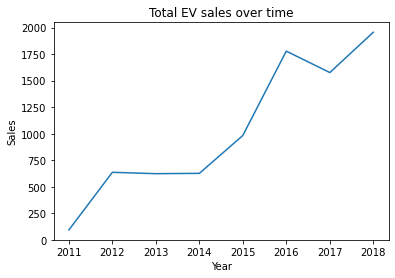

In [366]:
# Plot the time series

plt.figure(0)
plt.plot(State_df.Total)
plt.title('Total EV sales over time')
plt.ylabel('Sales')
plt.xlabel('Year')

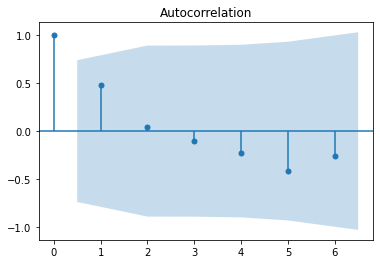

In [367]:
# Plot ACF
# Anything within the blue bars is statistically insignificant

acf_plot = plot_acf(State_df.Total[:-1])

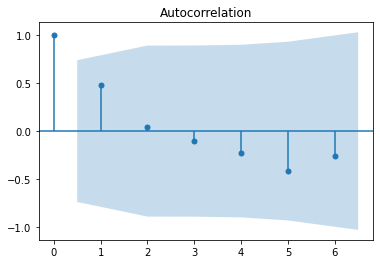

In [368]:
# Plot PACF
# Anything within the blue bars is statistically insignificant

pacf_plot = plot_acf(State_df.Total[:-1])

In [369]:
# Perform ADF test to check if time series is stationary
result = adfuller(State_df['Total'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.639468
p-value: 0.988549


In [370]:
# Find optimal (p,d,q)
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

warnings.filterwarnings("ignore")
best_cfg_EV = evaluate_models(State_df['Total'].values, p_values, d_values, q_values, np.column_stack([State_df['Gasoline_Price'].values,State_df['Median_Income'].values,State_df['Lithium_Price'].values]))

ARIMA(0, 0, 0) RMSE=524.366
ARIMA(0, 0, 1) RMSE=550.760
ARIMA(0, 0, 2) RMSE=616.654
ARIMA(0, 1, 0) RMSE=403.769
ARIMA(0, 1, 1) RMSE=523.019
ARIMA(0, 1, 2) RMSE=533.415
ARIMA(0, 2, 0) RMSE=518.958
ARIMA(0, 2, 1) RMSE=615.785
ARIMA(0, 2, 2) RMSE=518.780
ARIMA(1, 0, 0) RMSE=591.608
ARIMA(1, 0, 1) RMSE=581.820
ARIMA(1, 0, 2) RMSE=640.712
ARIMA(1, 1, 0) RMSE=512.972
ARIMA(1, 1, 1) RMSE=603.502
ARIMA(1, 1, 2) RMSE=509.888
ARIMA(1, 2, 0) RMSE=564.740
ARIMA(1, 2, 1) RMSE=681.805
ARIMA(1, 2, 2) RMSE=547.616
ARIMA(2, 0, 0) RMSE=649.786
ARIMA(2, 0, 1) RMSE=770.680
ARIMA(2, 0, 2) RMSE=653.564
ARIMA(2, 1, 0) RMSE=687.772
ARIMA(2, 1, 1) RMSE=797.969
ARIMA(2, 1, 2) RMSE=728.439
ARIMA(2, 2, 0) RMSE=1013.792
ARIMA(2, 2, 1) RMSE=620.919
ARIMA(2, 2, 2) RMSE=743.621
Best ARIMA(0, 1, 0) RMSE=403.769


In [371]:
p = best_cfg_EV[0]
d = best_cfg_EV[1]
q = best_cfg_EV[2]
#print(state_df['Total'].size)
#print(state_df['Gasoline Price'].size)
ARIMA_model = ARIMA(State_df['Total'],order=(p,d,q),exog=np.column_stack([State_df['Gasoline_Price'],State_df['Median_Income'],State_df['Lithium_Price']]))
ARIMA_model_fit = ARIMA_model.fit()
print(ARIMA_model_fit.summary())
    


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                    8
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -48.095
Date:                Fri, 01 Apr 2022   AIC                            104.190
Time:                        16:42:39   BIC                            103.973
Sample:                    01-01-2011   HQIC                           101.516
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -41.1265    492.649     -0.083      0.933   -1006.700     924.447
x2             0.1183      0.186      0.636      0.525      -0.246       0.483
x3            -2.6481      1.683     -1.574      0.1

In [372]:
# Forecast
Exog_df = pd.read_csv(filename2)
pred_sales = ARIMA_model_fit.forecast(15,exog=np.column_stack([Exog_df['Gasoline_Price_predicted'],Exog_df['Median_Income_predicted'],Exog_df['Lithium_Price_predicted']]), alpha=0.05)  # 95% conf

In [373]:
Predicted_df = pd.DataFrame(pred_sales)
Predicted_df.rename(columns={'predicted_mean':'Sales_predicted'},inplace=True)
Predicted_df.head()

,Sales_predicted
2019-01-01,1963.142317
2020-01-01,1951.587279
2021-01-01,1932.579399
2022-01-01,1910.556162
2023-01-01,1887.709227


In [374]:
Predicted_df.to_csv(filename3)